In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pydot
from IPython.display import display, SVG, clear_output

from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.all import (Parser, StartMeshcat, DiagramBuilder,
                        MeshcatVisualizerCpp, JacobianWrtVariable,
                        MakeRenderEngineVtk, RenderEngineVtkParams,
                        Simulator, CoulombFriction, HalfSpace, 
                        RotationMatrix, RotationalInertia,LogVectorOutput)
from pydrake.geometry import (
    Box,
    Cylinder
)

from pydrake.multibody.tree import (
    PrismaticJoint,
    UnitInertia,
    SpatialInertia,
    RevoluteJoint,
    FixedOffsetFrame,
    WeldJoint
)

from manipulation.meshcat_cpp_utils import MeshcatJointSliders
from manipulation.scenarios import AddMultibodyTriad
import modern_robotics as mr
from pydrake.systems.framework import LeafSystem

In [61]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7005


In [62]:
# Build robot from code
builder = DiagramBuilder()
step_size = 1e-3
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, step_size)

# Some parameters
L0 = 0.5
L1 = 0.7
L2 = 0.4

h = 0.06
w = 0.08
r = 0.05

m = 1

RGBA_Color = [0.5, 0.5, 0.5, 1]
mu = 0.4

my_model_instance = plant.AddModelInstance("my_robot")

inertia_link_0 = SpatialInertia.MakeFromCentralInertia(
    m, [0, 0, L0/2], RotationalInertia(m*(3*r**2+L0**2)/12, m*(3*r**2+L0**2)/12, m*r**2/2))
inertia_link_1 = SpatialInertia.MakeFromCentralInertia(
    m, [0, 0, L1/2], RotationalInertia(m*(w**2+L1**2)/12, m*(h**2+L1**2)/12, m*(h**2+w**2)/12))
inertia_link_2 = SpatialInertia.MakeFromCentralInertia(
    m, [0, 0, L2/2], RotationalInertia(m*(w**2+L2**2)/12, m*(h**2+L2**2)/12, m*(h**2+w**2)/12))

link_0 = plant.AddRigidBody(
    "link_0", my_model_instance, inertia_link_0)
link_1 = plant.AddRigidBody(
    "link_1", my_model_instance, inertia_link_1)
link_2 = plant.AddRigidBody(
    "link_2", my_model_instance, inertia_link_2)


plant.RegisterVisualGeometry(
    link_0,
    RigidTransform(RollPitchYaw(0, 0, 0), [0, 0, L0/2]),
    Cylinder(r, L0),
    "link_0",
    RGBA_Color)
plant.RegisterVisualGeometry(
    link_1,
    RigidTransform(RollPitchYaw(0, 0, 0), [0, 0, L1/2]),
    Box(h, w, L1),
    "link_1",
    RGBA_Color)
plant.RegisterVisualGeometry(
    link_2,
    RigidTransform(RollPitchYaw(0, 0, 0), [0, 0, L2/2]),
    Box(h, w, L2),
    "link_2",
    RGBA_Color)

frame_on_link_0 = plant.AddFrame(FixedOffsetFrame(
    link_0,
    RigidTransform(RollPitchYaw(0, 0, 0), [0, 0, L0])))

frame_on_link_1 = plant.AddFrame(FixedOffsetFrame(
    link_1,
    RigidTransform(RollPitchYaw(0, 0, 0), [0, 0, L1])))

plant.AddJoint(RevoluteJoint(
    name="joint_0_to_1", frame_on_parent=frame_on_link_0,
    frame_on_child=link_1.body_frame(), axis=[1, 0, 0]))

plant.AddJoint(RevoluteJoint(
    name="joint_1_to_2", frame_on_parent=frame_on_link_1,
    frame_on_child=link_2.body_frame(), axis=[1, 0, 0]))

plant.WeldFrames(
    frame_on_parent_P=plant.world_frame(),
    frame_on_child_C=link_0.body_frame(),
    X_PC=RigidTransform(RollPitchYaw(0, 0, 0), [0, 0, 0]))

# Draw RGB frames for visualization
for body_name in ["link_0", "link_1", "link_2"]:
    AddMultibodyTriad(plant.GetFrameByName(body_name), scene_graph, 0.20, 0.008)

# Finalize and visualize
plant.Finalize()

renderer_name = "renderer"
scene_graph.AddRenderer(
    renderer_name, MakeRenderEngineVtk(RenderEngineVtkParams()))

meshcat.Delete()
meshcat_vis = MeshcatVisualizerCpp.AddToBuilder(
    builder, scene_graph, meshcat)

logger=LogVectorOutput(plant.get_state_output_port(), builder)

diagram = builder.Build()

diagram_context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(diagram_context)
plant.SetPositions(plant_context, plant.GetModelInstanceByName("my_robot"),
                   [1.0, 2.0])  # theta1, theta2

diagram.Publish(diagram_context)

simulator = Simulator(diagram, diagram_context)
simulator.set_publish_every_time_step(True)
simulator.set_target_realtime_rate(1)
simulator.Initialize()
diagram.Publish(diagram_context)
simulator.AdvanceTo(10)


In [63]:
# please write your own simulator below
import mydynamics as md

# kinematics parameters
L0 = 0.5
L1 = 0.7
L2 = 0.4

h = 0.06
w = 0.08
r = 0.05

m = 1 #link mass i=1,2

n=2 # n-joints

# body twist:  i-th scewaxis  w.r.t link i
tw1b=md.generate_twist(0,0,0,1,0,0)
tw2b=md.generate_twist(0,0,0,1,0,0)
tw_b_all=np.concatenate((np.array([tw1b]),np.array([tw2b]))).T


#  all links' kinematics para and inertia para
g_i=np.zeros((4,4,n))
I_i=np.zeros((6,6,n))

# link 1 g_i(i)=g_{i-1,i} ith inetia expressed in link i frame
g_i[0:3,0:3,0]=md.xyz_spatial(0,0,0)
g_i[0:3,3,0]=np.array([0,0,L0])
g_i[3,3,0]=1
Ic=np.array([[(w**2+L1**2)/12,0,0],
                     [0,(h**2+L1**2)/12,0],
                     [0,0,(w**2+h**2)/12]])
I_i[:,:,0]=md.spatialinertia_fromCoM(md.generate_SE3((0,0,0),np.array([0,0,L1/2])),m,Ic)

# link 2 g_i(i)=g_{i-1,i} ith inetia expressed in link i frame
g_i[0:3,0:3,1]=md.xyz_spatial(0,0,0)
g_i[0:3,3,1]=np.array([0,0,L1])
g_i[3,3,1]=1
Ic=np.array([[(w**2+L2**2)/12,0,0],
                     [0,(h**2+L2**2)/12,0],
                     [0,0,(w**2+h**2)/12]])
I_i[:,:,1]=md.spatialinertia_fromCoM(md.generate_SE3((0,0,0),np.array([0,0,L2/2])),m,Ic)

def RNEA(q,dq,ddq,graivity):
    # graivity is a positive value
    # No F_ext here

    # q=np.array([q1,q2,...,qn]) nx1
    # q=np.array([dq1,dq2,...,dqn]) nx1
    # q=np.array([ddq1,ddq2,...,ddqn]) nx1

    V=np.zeros((6,n))
    A=np.zeros((6,n))
    F=np.zeros((6,n))
    tau=np.zeros(n)
    Ag=np.array([0,0,0,0,0,graivity])
    for i in range(n):
        if i==0:
            V[:,i]=tw_b_all[:,i]*dq[i]
            A[:,i]=md.Ad_g_inv(g_i[:,:,i]@md.exp_g(tw_b_all[:,i],q[i]))@Ag+tw_b_all[:,i]*ddq[i]+md.ad_V(V[:,i])@tw_b_all[:,i]*dq[i]
        else:
            V[:,i]=md.Ad_g_inv(g_i[:,:,i]@md.exp_g(tw_b_all[:,i],q[i]))@V[:,i-1]+tw_b_all[:,i]*dq[i]
            A[:,i]=md.Ad_g_inv(g_i[:,:,i]@md.exp_g(tw_b_all[:,i],q[i]))@A[:,i-1]+tw_b_all[:,i]*ddq[i]+md.ad_V(V[:,i])@tw_b_all[:,i]*dq[i]
        F[:,i]=I_i[:,:,i]@A[:,i]-md.ad_V(V[:,i]).T@I_i[:,:,i]@V[:,i]
    for i in range(n-1,-1,-1):
        tau[i]=tw_b_all[:,i]@F[:,i]
        if i!=0:
            F[:,i-1]=F[:,i-1]+md.Ad_g_inv(g_i[:,:,i]@md.exp_g(tw_b_all[:,i],q[i])).T@F[:,i]
    return tau

def inertiamatrix(q):
    # inertia matrix by Composite-Rigid-Body Algorithm
    M=np.zeros((n,n))
    I_i_composite=I_i.copy()
    for i in range(n-1,-1,-1):
        if i-1 >=0 :
            X_star=md.Ad_g_inv(g_i[:,:,i]@md.exp_g(tw_b_all[:,i],q[i])).T
            X=md.Ad_g_inv(g_i[:,:,i]@md.exp_g(tw_b_all[:,i],q[i]))
            I_i_composite[:,:,i-1]=I_i_composite[:,:,i-1]+X_star@I_i_composite[:,:,i]@X
        F=I_i_composite[:,:,i]@tw_b_all[:,i]
        M[i,i]=tw_b_all[:,i]@F
        j=i
        while j-1>=0 :
            F=md.Ad_g_inv(g_i[:,:,j]@md.exp_g(tw_b_all[:,j],q[j])).T@F
            j=j-1
            M[i,j]=F@tw_b_all[:,j]
            M[j,i]=M[i,j].T   
    return M

def FD(q,dq,tau,gravity):
    C_N_all=RNEA(q,dq,np.zeros(n),gravity)
    
    # You can use RNEA to get M 
    # M = np.zeros((n,n))
    # for i in range(n):
    #     ddq=np.identity(n)[:,i]
    #     M[:,i]=RNEA(q,np.zeros(n),ddq,0)

    # Here we using Composite-Rigid-Body Algorithm to compute inertia matrix
    M=inertiamatrix(q)

    ddq=np.linalg.solve(M,tau-C_N_all)
    return ddq


### (b)

In [64]:
# Test 
q=np.array([1,2.0])
dq=np.array([1.0,2.0])
ddq=np.array([1.0,2.0])

tau=RNEA(q,dq,ddq,9.8)
print(tau)

[-9.37132033 -0.04595413]


### (c)

In [65]:
# Test 
q=np.array([1.0,2.0])
dq=np.array([1.0,2.0])
tau=np.array([1.0,2.0])

ddq=FD(q,dq,tau,9.8)
print(ddq)

[18.8355595  41.43666388]


### (d)

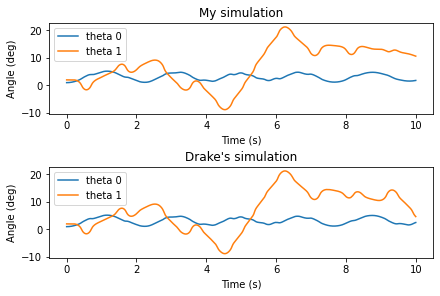

In [66]:
# Initial states:
q=np.array([1.0,2.0])
dq=np.array([0,0.0])
ddq=np.array([0.0,0.0])

delat_t=0.001
totaltime=10
step_num=round(totaltime/delat_t)
my_q=np.zeros((step_num,2))
for i in range(step_num):
    dq+=ddq*delat_t
    q+=dq*delat_t
    ddq=FD(q,dq,0,9.8)
    my_q[i,:]=q


# Plot the data
t=np.linspace(0,totaltime,round(totaltime/delat_t))
fig1, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
ax1.plot(t,my_q[:,0],label = "theta 0")
ax1.plot(t,my_q[:,1],label = 'theta 1')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Angle (deg)")
ax1.set_title("My simulation")
ax1.legend()

log=logger.FindLog(diagram_context)
ax2.plot(log.sample_times(),log.data()[0,:],label = "theta 0")
ax2.plot(log.sample_times(),log.data()[1,:],label = "theta 1")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Angle (deg)")
ax2.set_title("Drake's simulation")
ax2.legend()

plt.show()